# **Self Organizing Maps for Covid 19 Articles:**
## *Understanding the Topology of Corona Literature*

In [4]:
### importing dependencies ###
import numpy as np 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom

### tokenizers #####
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import wordpunct_tokenize

### DTM tehcniques ###
from sklearn.feature_extraction.text import TfidfTransformer
from nltk import wordpunct_tokenize
from nltk import word_tokenize 


## DTM Makers ####
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
from nltk import wordpunct_tokenize
import nltk
nltk.download("stopwords")

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MinMaxScaler
import sys
import matplotlib.pyplot as plt
!pip install minisom
import seaborn as sns 
import matplotlib.pyplot as plt
import sys

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
master_text = pd.read_csv("/content/drive/My Drive/covid 19 exploration/mycode/master_text.csv")

# **Creating a DTM**

In [9]:
### Stop Words ####
en_stop = stopwords.words('english')

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

# Additions to the stop word list
en_stop.extend([".","-","(", ")","/", r",+", "’", "”","“", "\n",r"\\)","!","?",r"\\(",r"\\'",r'\\"','covid', 'use','doi','peerreview','et','al'])

stem_function= PorterStemmer
port=PorterStemmer

## stemer function
def stemer(tokens, stem_function):
    stems=[]
    for token in tokens:
        stem=port().stem(token)
        stems.append(stem)
    return stems

## tokenizes words
def tokenizer(text):
    text=re.sub("[^a-z|^\s]", "",  text) # regex to get ride of function
    toks=wordpunct_tokenize(text.lower()) # converting everything to lower case
    stemed=stemer(toks, stem_function)
    return stemed


####### Abstract to DTM ##########
abstracts = master_text[~master_text.abstract.isna()]

abstracts = abstracts ### temporary, just so i can continue to code   


word_list = abstracts.main_text.to_list()  
vect = CountVectorizer(tokenizer=tokenizer, stop_words = en_stop, ngram_range= (1,2), max_features = 1000)
vect.fit(word_list)
dtm = vect.transform(word_list)   
df2 = pd.DataFrame(dtm.toarray(), columns=vect.get_feature_names())
df2.to_csv('dtm.csv')
df2.head()




/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'arent', 'becaus', 'befor', 'couldnt', 'didnt', 'doe', 'doesnt', 'dont', 'dure', 'ha', 'hadnt', 'hasnt', 'havent', 'hi', 'isnt', 'mightnt', 'mustnt', 'neednt', 'onc', 'onli', 'ourselv', 'shant', 'shouldnt', 'shouldv', 'thatll', 'themselv', 'thi', 'veri', 'wa', 'wasnt', 'werent', 'whi', 'wont', 'wouldnt', 'youd', 'youll', 'yourselv', 'youv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,aa,ab,abil,abl,abov,absenc,access,accord,account,accumul,ace,achiev,acid,across,act,action,activ,acut,acut respiratori,ad,adapt,addit,address,administr,adult,affect,affin,age,agent,aim,air,align,allow,alon,along,also,alter,altern,although,amino,...,viru infect,virul,virus,vitro,vivo,volum,vp,vs,wa,wa ad,wa also,wa detect,wa determin,wa found,wa observ,wa perform,wash,water,way,week,weight,well,western,western blot,wherea,whether,whole,wide,wild,wildtyp,within,without,work,world,would,wt,x,year,yet,yield
0,0,0,0,1,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,11,0,1,2,0,0,4,0,...,0,0,3,2,0,0,4,0,26,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,11,0,0,0,5,0,0,0,0
1,0,0,4,2,4,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,4,7,0,0,0,0,0,1,0,0,0,10,16,0,0,5,0,1,1,0,...,0,0,5,0,0,1,0,0,58,0,1,4,1,0,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,6,14,1,0,2,0,0,0,0,1
2,0,4,0,1,1,1,3,0,0,0,0,0,0,0,0,0,4,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,2,0,2,14,0,0,1,0,...,2,0,0,0,0,0,0,2,12,0,0,0,0,0,0,1,0,0,0,0,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0
3,0,0,0,0,2,0,3,2,1,0,0,0,0,16,0,0,1,0,0,0,0,5,1,0,0,2,0,0,0,1,13,0,0,0,0,7,0,0,1,0,...,0,0,0,0,0,15,0,0,25,0,0,0,0,0,0,1,0,0,0,18,0,3,0,0,0,0,0,1,0,0,9,1,0,6,5,0,0,7,0,0
4,0,0,1,1,2,0,0,4,1,3,21,0,0,0,0,1,7,3,1,1,0,5,0,0,0,0,0,0,0,1,0,0,8,0,0,11,0,0,5,0,...,2,0,6,0,1,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,0,4,0,0,0,8,0,0,0,0,0,0,0,0


In [0]:
### exploring the top words 
df2.sum(axis=0).sort_values(ascending=False)[0:50]

# **Using a Tfidf L1 Normalized Matrixs**

In [0]:
######## Creating L1 normalized term freq matrixs
tfdif = Transformer(norm='l1', use_idf=True)
dtm_l1 = tfdif.fit_transform(df2)

### l2 DTM #####
dtm_l1=pd.DataFrame(dtm_l1.toarray(), columns=vect.get_feature_names(), index = abstracts.index)
dtm_l1=pd.concat([abstracts.paper_id,  dtm_l1], axis=1)

dtm_l1.to_csv('/content/drive/My Drive/covid 19 exploration/df/dtm_l1.csv')

  # **Trianing / Building a Self Organized Map:**

  Key terms: <br>

  quantization error : Average distance between each data vector and its BMU.
       Measures map resolution. <br>
  Topographic Error : Topographic error, the proportion of all data vectors
       for which first and second BMUs are not adjacent units.
       Measures topology preservation.

      

iteration=21199 status=99.70%

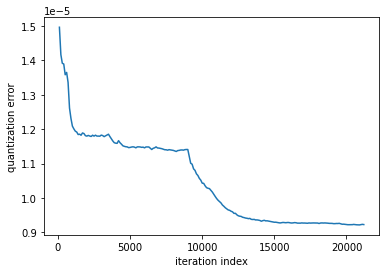

Text(0.5, 0, 'iteration index')

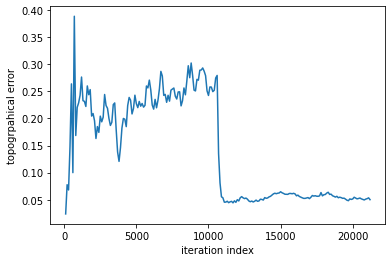

In [17]:
#### 10, 10, lr = .05, buble sigma, 3, iteration = 5000 
dtm_l1 = pd.read_csv('/content/drive/My Drive/covid 19 exploration/df/dtm_l1.csv') 

som = MiniSom(x=10, y=10, input_len=dtm_l1.iloc[:,2:].shape[1] , sigma=4, learning_rate=0.05, neighborhood_function='bubble', random_seed=10)

X = dtm_l1.iloc[:,2:].values

data=X
som.pca_weights_init(X)
max_iter = 21264
q_error = []
t_error = []
iter_x = []


for i in range(max_iter):
    percent = 100*(i+1)/max_iter
    rand_i = np.random.randint(len(data)) # This corresponds to train_random() method.
    som.update(data[i], som.winner(data[i]), i, max_iter)
    if (i+1) % 100 == 0:
        q_error.append(som.quantization_error(data))
        t_error.append(som.topographic_error(data))
        iter_x.append(i)
        sys.stdout.write(f'\riteration={i:2d} status={percent:0.2f}%')
        
plt.plot(iter_x, q_error)
plt.ylabel('quantization error')
plt.xlabel('iteration index')
plt.show()

plt.plot(iter_x, t_error)
plt.ylabel('topogrpahical error')
plt.xlabel('iteration index')

cord=[som.winner(row) for row in data]
dtm_l1['cord'] = pd.Series(cord)

# **Analysis**
### **Graph One**: Distance Matrixs overlayed with Frequencey counts <br>
### **Graph two**: Freq Matrixs overlayed with Frequencey counts

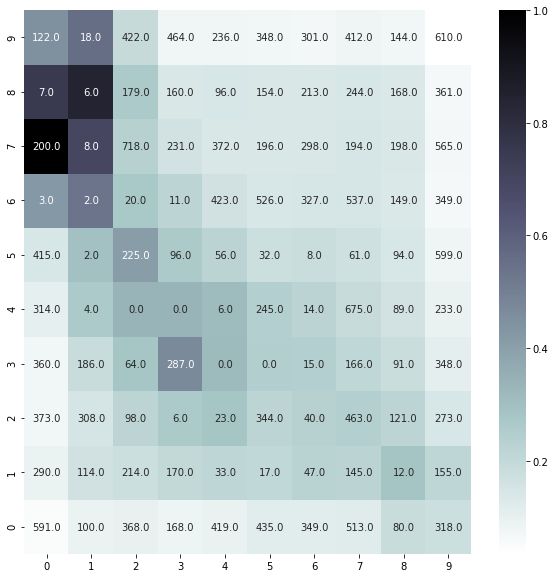

In [18]:
import seaborn as sns
distance = som.distance_map().T
frequencies = som.activation_response(data=data).T

fig, ax = plt.subplots(figsize=(10,10))
g = sns.heatmap(distance, cmap='bone_r', ax=ax, annot=frequencies, fmt='1')
ax.invert_yaxis()

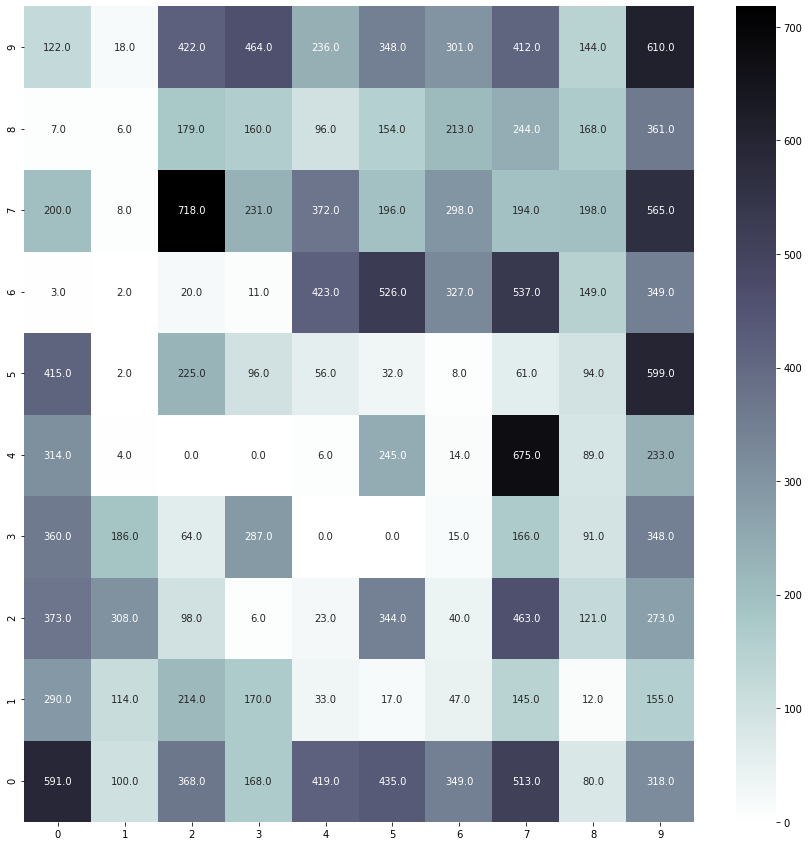

In [19]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,15))
g = sns.heatmap(frequencies, cmap='bone_r', ax=ax, annot=frequencies, fmt='1')
g.invert_yaxis()


In [73]:
master_text = pd.read_csv("/content/drive/My Drive/covid 19 exploration/mycode/master_text.csv")
master_text

,Unnamed: 0,paper_id,papepr_title,abstract,main_text,file_path
0,0,0015023cc06b5362d332b3baf348d11567ca2fbb,The RNA pseudoknots in foot-and-mouth disease ...,word count: 194 22 Text word count: 5168 23 2...,"VP3, and VP0 (which is further processed to V...",biorxiv_medrxi
1,1,004f0f8bb66cf446678dc13cf2701feec4f36d76,Healthcare-resource-adjusted vulnerabilities t...,NaN,The 2019-nCoV epidemic has spread across Chin...,biorxiv_medrxi
2,2,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,"Real-time, MinION-based, amplicon sequencing f...",Infectious bronchitis (IB) causes significant...,"Infectious bronchitis (IB), which is caused b...",biorxiv_medrxi
3,3,0139ea4ca580af99b602c6435368e7fdbefacb03,A Combined Evidence Approach to Prioritize Nip...,Nipah Virus (NiV) came into limelight recentl...,Nipah is an infectious negative-sense single-...,biorxiv_medrxi
4,4,013d9d1cba8a54d5d3718c229b812d7cf91b6c89,Assessing spread risk of Wuhan novel coronavir...,Background: A novel coronavirus (2019-nCoV) e...,"In December 2019, a cluster of patients with ...",biorxiv_medrxi
...,...,...,...,...,...,...
29310,29310,ff5a79ed22ea416e6d89caad1cf0d83dbc741a4b,Understanding Human Coronavirus HCoV-NL63,Even though coronavirus infection of humans i...,"Regardless of geographic location, respirator...",noncomm_use_subse
29311,29311,ff6d57f2aad99be129432058665b361dc18747e8,Brief Definitive Report MACROPHAGES GENETICALL...,There is extensive evidence that cultured mac...,Experiments were designed to test whether sub...,noncomm_use_subse
29312,29312,ff83907653a4c4500e8c509ca28169e924742b40,Identification of a Subdomain of CENPB That Is...,We have combined in vivo and in vitro approac...,"can function in an autonomous fashion, reloca...",noncomm_use_subse
29313,29313,ffe718db1820f27bf274e3fc519ab78e450de288,Replication enhancer elements within the open ...,We provide experimental evidence of a replica...,Tick-borne encephalitis virus (TBEV) is a hum...,noncomm_use_subse


In [71]:
#### analyzing the outliers


print(dtm_l1[dtm_l1.cord == (7,4)].iloc[:,2:-1].sum().sort_values(ascending=False)[0:50])

antibodi    14.646399
wa          10.746021
mab         10.499066
protein      8.094425
cell         7.332795
neutral      7.232191
epitop       6.954361
antigen      6.117824
elisa        5.849152
igg          5.070195
sera         4.858147
immun        4.502514
serum        4.203557
bind         4.177889
infect       4.096358
viru         4.064091
sarscov      3.856534
c            3.646658
thi          3.506642
peptid       3.337615
fig          3.322639
dilut        3.249881
assay        3.210452
recombin     3.174112
titer        3.155230
vaccin       3.062022
express      2.976660
h            2.949726
mice         2.917826
sampl        2.892893
gp           2.843835
test         2.816462
incub        2.805014
detect       2.787428
plate        2.678701
sequenc      2.658096
b            2.625910
clone        2.492749
tgev         2.490998
human        2.413379
specif       2.378362
anim         2.296284
e            2.284404
respons      2.252414
studi        2.249762
purifi    

In [79]:
abstracts = master_text[~master_text.abstract.isna()]

abstracts[abstracts.paper_id.isin(dtm_l1[dtm_l1.cord == (0,7)].paper_id.to_list())]

,Unnamed: 0,paper_id,papepr_title,abstract,main_text,file_path
2054,2054,21f0073aa9c5c592c81fd9db4e11d61a35865cf7,LISTE DES PARTICIPANTS Comité de pilotage Méth...,Essai randomisé en double insu comparant l'as...,Essai randomisé en double insu testant l'effi...,comm_use_subse
7206,7206,af400a711649c6703b915e8a935dfe778bc42132,PROTOCOLO CLÍNICO DE PESQUISA Estudo de Fase I...,Este protocolo é propriedade dos pesquisadore...,Todas as perguntas referentes a este protocol...,comm_use_subse
10008,10008,000eec3f1e93c3792454ac59415c928ce3a6b4ad,Pneumonie virale sévère de l'immunocompétent V...,Reçu et accepté le 7 février 2004 Les infecti...,Les pathologies infectieuses respiratoires so...,custom_licens
10060,10060,00e7a32a8286cd9eb5b2b570fba0417547863f18,IMMUNITI INN#E AUX INTERFACES ET COGNITIVE MUQ...,"Les interfaces epitheliales muqueuses, indisp...","Marie-Christine Ben6 a,*, Gilbert C. Faure a ...",custom_licens
10078,10078,0129fd3130ef50c5b2a994944c7bb4e8df7fce8a,Poster 1 Évaluation de l'impact de la diffusio...,La revue de médecine interne 25 (2004) S410-S...,Introduction. -Du fait du problème de santé p...,custom_licens
...,...,...,...,...,...,...
26487,26487,f8e47f4854a644c766f1db3004f7326fe528549e,NaN,"publicly funded repositories, such as the WHO...",Etiologie des gastro-ent6rites aigues infanti...,custom_licens
26591,26591,fa4ef93ece8b5a4493375d6afc55e37578670879,Pathologie infectieuse Virus émergents ou mena...,Les virus émergents ont défrayé la chronique ...,Depuis le développement de la virologie moder...,custom_licens
26692,26692,fbc5841dfb71e2b468e97635a2eb273a6492be2d,Les infections à coronavirus humains,"publicly funded repositories, such as the WHO...",Les coronavirus humains (HCoV) sont à l'origi...,custom_licens
26751,26751,fcb71277a18026610b923cc9c48b5889af3839b0,NaN,"publicly funded repositories, such as the WHO...","La diarrhée et le ténesme, associés à de l'hé...",custom_licens


### After a carful evaluation of the evidence, the outliers found above can consdiered... not english... so much work
